In [1]:
import numpy as np
import pandas as pd
from random import randint
import math
from PIL import Image, ImageDraw
from PIL import ImagePath 
from imutils import rotate
import matplotlib.pyplot as plt
from skimage.transform import radon



# from dataset_generator import generate_polygon, calculate_angles
from dataset_generator import create_dataset #, generate_polygon, generate_polygon_subroutine
from utils import mse_error, reconstruct, get_split, choose_top_angles, get_non_binary_angles, transform_angles_data

average mse error for 50 polygon-shaped pics: 0.0


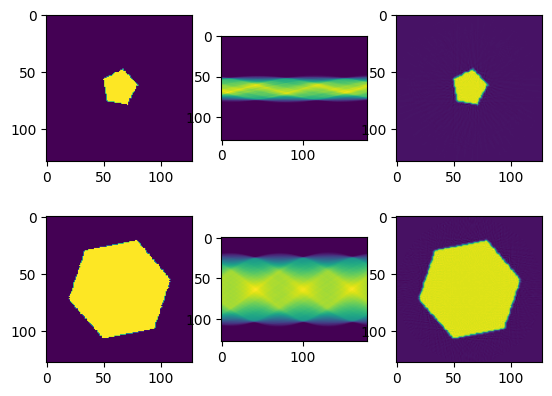

In [2]:
# images_list, sinograms_list, angles_list = create_dataset(20000, single_side_size = None, img_size = 64 * 2)
images_list, sinograms_list, angles_list = create_dataset(100, single_side_size = None, img_size = 64 * 2)
reconstruct_list = reconstruct(sinograms_list)
print("average mse error for 50 polygon-shaped pics:", mse_error(images_list, reconstruct_list))
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(images_list[0]) 
axarr[0,1].imshow(sinograms_list[0])
axarr[0,2].imshow(reconstruct_list[0])
axarr[1,0].imshow(images_list[1])
axarr[1,1].imshow(sinograms_list[1])
axarr[1,2].imshow(reconstruct_list[1])

# Sandbox area:

In [3]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


def create_model(img_size = 64):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='random_normal',),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='random_normal',),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',),
        layers.MaxPooling2D((2, 2)),

        # layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',),
        # layers.MaxPooling2D((2, 2)), # Might increase performance because it decreases parameters (which is why CNN was created for in the first place)
        # Sams model has 85% of params in dense layer
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(1000, activation="relu", kernel_initializer='random_normal',),
        tf.keras.layers.Dense(500, activation="relu", kernel_initializer='random_normal',),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(180, activation="sigmoid", kernel_initializer='random_normal',),
    ])

    return model

2022-12-09 11:08:57.754037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = create_model(64)
model.build((None, 128, 180, 1))

2022-12-09 11:09:10.371078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


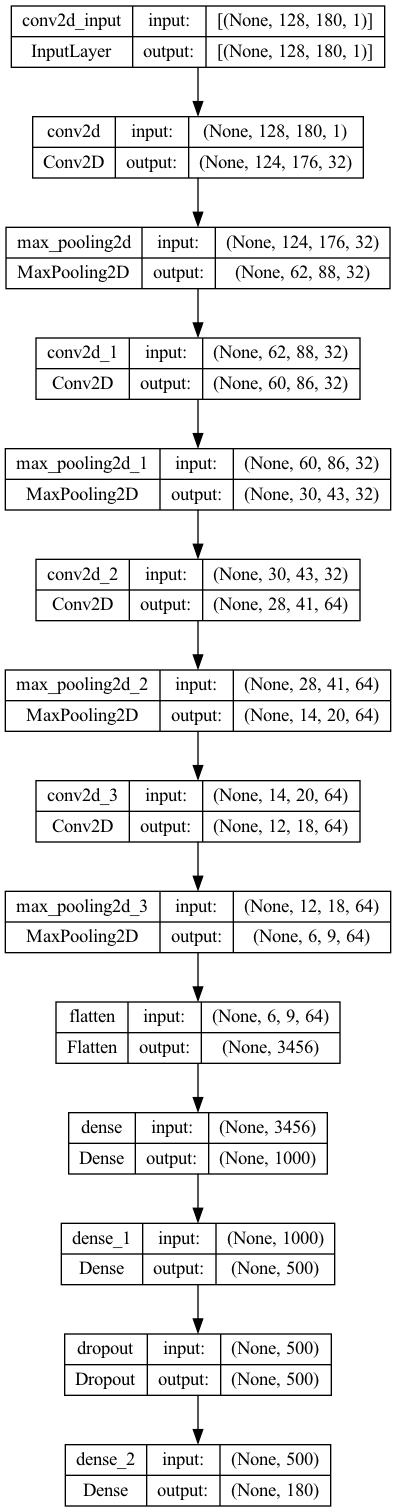

In [5]:
# model = create_model(64)
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

# callbacks = [
#              EarlyStopping(patience=2),
#              model_checkpoint_callback,
# ]

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 176, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 86, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 41, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 20, 64)       0

In [8]:
def transform_angles_data(angles_list):
    def sigmoid(x):
        return 1 / (1 + math.exp(-x))
    assert np.array(angles_list).ndim == 2
    angles_list_copy = np.array(angles_list).copy()
    output_angles = []
    
    for angles in angles_list_copy:
        angles_indices = get_non_binary_angles(angles)
        nr_angles = len(angles_indices)
        # Change from -10 to 10  (therefore value 20)
        CONST = int(180/2/nr_angles)
        for angle in angles_indices:
            for i in range(0,CONST + 1):
                if i == 0 : iter = 10
                else : iter = round(10 - (20 * i / CONST),2)
                angles[(angle + i)%180] = iter
                angles[angle - i] = iter
        # Transform values from -10 to 10 into more smooth line using sigmoid function
        # print("angles:", angles)
        angles_ = []
        for iter, angle in enumerate(angles):
            angles_.append(round(sigmoid(angle),4))
        output_angles.append(angles_)
        # print(angles_)
        # break
        
    return output_angles
    
transformed = transform_angles_data(angles_list)
X_train, X_test, y_train, y_test = get_split(sinograms_list, transformed)


## Choose one of the cells below:
##### Load model:

In [9]:
model = tf.keras.models.load_model('saved_model/my_model')


##### Train model:

In [9]:
history = model.fit(X_train,y_train, batch_size=200, epochs=100,validation_data=(X_test,y_test))

Epoch 1/200
70/70 [==============================] - 217s 3s/step - loss: 0.1841 - accuracy: 0.0293 - val_loss: 0.0638 - val_accuracy: 0.0600
Epoch 2/200
70/70 [==============================] - 196s 3s/step - loss: 0.0681 - accuracy: 0.0441 - val_loss: 0.0504 - val_accuracy: 0.0735
Epoch 3/200
70/70 [==============================] - 192s 3s/step - loss: 0.0558 - accuracy: 0.0502 - val_loss: 0.0425 - val_accuracy: 0.0788
Epoch 4/200
70/70 [==============================] - 193s 3s/step - loss: 0.0487 - accuracy: 0.0557 - val_loss: 0.0382 - val_accuracy: 0.0632
Epoch 5/200
70/70 [==============================] - 191s 3s/step - loss: 0.0442 - accuracy: 0.0538 - val_loss: 0.0344 - val_accuracy: 0.0673
Epoch 6/200
70/70 [==============================] - 193s 3s/step - loss: 0.0403 - accuracy: 0.0590 - val_loss: 0.0321 - val_accuracy: 0.0767
Epoch 7/200
70/70 [==============================] - 192s 3s/step - loss: 0.0371 - accuracy: 0.0610 - val_loss: 0.0292 - val_accuracy: 0.0985
Epoch 

KeyboardInterrupt: 

In [10]:
predictions = model.predict(X_test)

1/1 [==============================] - 0s 395ms/step


In [14]:
np.array(X_train[0]).shape

(128, 180)

In [20]:
# plt.imshow(reconstruct(X_test[3]))

In [11]:
i = 10
for (truth, prediction) in zip(y_test, predictions):
    real_angles = choose_top_angles(truth)
    predicted_angles = choose_top_angles(prediction)
    print("truth:", real_angles)
    print("prediction:", predicted_angles)
    print()
    i+=1
    if i == 10 :
        break

truth: [17, 77, 137]
prediction: [17, 77, 137]

truth: [40, 100, 160]
prediction: [41, 101, 161]

truth: [13, 73, 133]
prediction: [13, 73, 133]

truth: [79, 166]
prediction: [79, 166]

truth: [10, 48, 120]
prediction: [9, 48, 120]

truth: [33, 93, 153]
prediction: [33, 92, 153]

truth: [28, 88, 148]
prediction: [28, 89, 149]

truth: [66, 156]
prediction: [66, 156]

truth: [22, 112]
prediction: [23, 112]

truth: [45, 83, 155]
prediction: [45, 83, 155]

truth: [14, 52, 124]
prediction: [14, 52, 124]

truth: [7, 89, 171]
prediction: [7, 90, 171]

truth: [46, 106, 166]
prediction: [46, 106, 166]

truth: [7, 44, 116]
prediction: [7, 44, 116]

truth: [25, 85, 145]
prediction: [25, 85, 145]

truth: [68, 106, 173]
prediction: [5, 67, 106, 173]

truth: [66, 104, 172]
prediction: [65, 104, 171]

truth: [25, 85, 145]
prediction: [25, 85, 145]

truth: [31, 69, 141]
prediction: [30, 69, 141]

truth: [41, 101, 161]
prediction: [42, 101, 162]

truth: [28, 88, 148]
prediction: [28, 88, 148]

truth: [

In [12]:
# Un-comment to save the model
# model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets
